# Univariate timeseries

In [2]:
# Disable warnings
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sktime.transformations.series.fourier import FourierFeatures
from sktime.forecasting.compose import ForecastingPipeline
from numpyro import distributions as dist

# Import dataset

We import a dataset from Prophet's original repository. We then put it into sktime-friendly format, where the index is a `pd.PeriodIndex` and the colums are the time series.

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
)
df["ds"] = pd.to_datetime(df["ds"]).dt.to_period("D")
y = df.set_index("ds")
display(y)

,y
ds,
2007-12-10,9.590761
2007-12-11,8.519590
2007-12-12,8.183677
2007-12-13,8.072467
2007-12-14,7.893572
...,...
2016-01-16,7.817223
2016-01-17,9.273878
2016-01-18,10.333775


# Fit model

Here, we fit the univariate Prophet. Note that we are not using any external regressors but, because of `yearly_seasonality=True`and `weekly_seasonality=True`, they are built internally with sktime's FourierFeatures. As `exogenous_priors` is not passed as hyperparameter, the default values are used for all regressor variables (including the Fourier features). 

In [4]:
from hierarchical_prophet.sktime.prophet import Prophet

model = Prophet(
    trend="linear",
    changepoint_interval=300,
    changepoint_prior_scale=0.0001,
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=True,
    default_exogenous_prior=("Normal", 0, 0.01),
    noise_scale=0.05,
    mcmc_chains=1,
    mcmc_samples=300,
    mcmc_warmup=3000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="map",
)
model.fit(y=y)

100%|██████████| 100000/100000 [00:09<00:00, 10219.46it/s, init loss: 28192.6426, avg. loss [95001-100000]: -5148.8452]


Prophet(capacity_prior_scale=0.11806968356353145, changepoint_interval=300,
        changepoint_prior_scale=0.0001,
        default_exogenous_prior=('Normal', 0, 0.01), inference_method='map',
        mcmc_chains=1, mcmc_samples=300, mcmc_warmup=3000,
        optimizer_kwargs={'step_size': 0.0001}, weekly_seasonality=True,
        yearly_seasonality=True)

## Forecasting

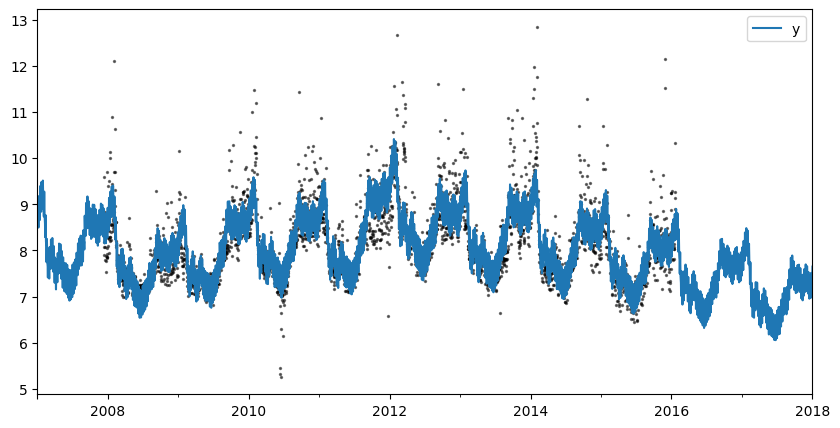

In [5]:
forecast_horizon = pd.period_range("2007-01-01", "2018-01-01", freq="D")
fig, ax = plt.subplots(figsize=(10, 5))
preds = model.predict(fh=forecast_horizon)
preds.plot.line(ax=ax)
ax.scatter(y.index, y, marker="o", color="k", s=2, alpha=0.5)

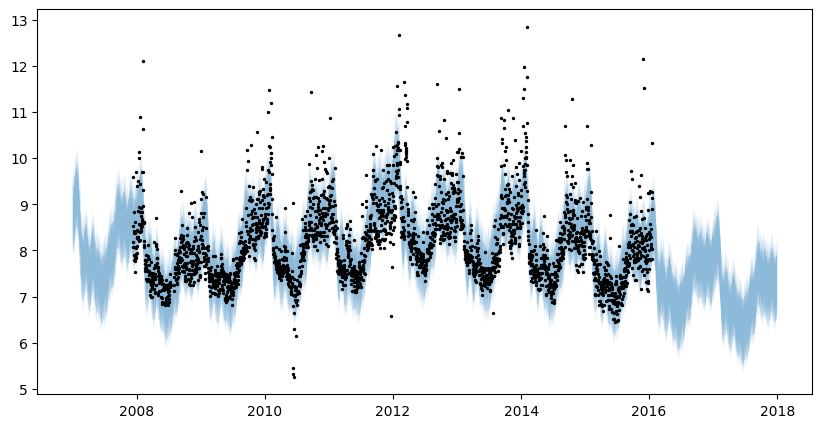

In [6]:
quantiles = model.predict_quantiles(fh=forecast_horizon, alpha=[0.1, 0.9])
fig, ax = plt.subplots(figsize=(10, 5))
# Plot area between quantiles
ax.fill_between(quantiles.index.to_timestamp(), quantiles.iloc[:, 0], quantiles.iloc[:, -1], alpha=0.5)
ax.scatter(y.index, y, marker="o", color="k", s=2, alpha=1)